In [1]:
import os
import sys
import statistics as st

from chefboost import Chefboost as chef
import random
import pandas as pd
import numpy as np
import warnings

try:
    sys.path.index(os.path.join(os.getenv('GitHub'), 'driving_behavior_analysis'))
except:                                                                                 
    sys.path.append(os.path.join(os.getenv('GitHub'), 'driving_behavior_analysis'))
#import src_py.utils.global_constants as gc

import src_py.lib.classification_preprocessing as cprp

import src_py.lib.classification_metrics as cmet


# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector, ColumnTransformer

# Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn import tree

# Visualization
import matplotlib.pyplot as plt

# Tuning the hyper-parameters 
from sklearn.model_selection import GridSearchCV

#PCA
from sklearn.decomposition import PCA

# Apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Isolation Forest
from sklearn.ensemble import IsolationForest

dataframe per test : 'kl_train__2022-03-30.csv'

In [2]:
import src_py.lib.classification_preprocessing as cprp
import src_py.lib.classification_metrics as cmet

In [3]:
filename ='merged_dataset_with_4dfs.csv' #'4cl_balanced_3dfs.csv' #'binary_4cl_balanced_3dfs.csv' #'binary_merged_dataset_with_3dfs.csv' #'merged_dataset_with_3dfs.csv' #'binary_merged_dataset_with_2dfs.csv'

# Features' names
imei_col = 'imei'
acc_col = 'acc'
brk_col = 'brk'
corn_col = 'corn'

# Target variable name
target = 'results'

In [4]:
df = pd.read_csv(os.path.join(os.getenv('GitHub'), 
                                filename))

# Cast IMEI and target to string
df[imei_col] = df[imei_col].astype(str)
df[target] = df[target].astype(str)

In [5]:
df

,imei,acc_1,brk_1,corn_1,acc_2,brk_2,corn_2,acc_3,brk_3,corn_3,...,acc_28,brk_28,corn_28,acc_29,brk_29,corn_29,acc_30,brk_30,corn_30,results
0,861914034070078,0.0,0.0,13.0,0.0,0.0,20.0,0.0,0.0,29.0,...,0.0,0.0,32.0,0.0,0.0,15.0,0.0,0.0,32.0,Failing for distribution
1,860788040171414,0.0,4.0,51.0,4.0,6.0,109.0,0.0,1.0,11.0,...,1.0,2.0,32.0,0.0,1.0,66.0,1.0,9.0,113.0,Ok
2,861914035513118,3.0,2.0,13.0,9.0,16.0,48.0,1.0,5.0,16.0,...,0.0,3.0,18.0,2.0,2.0,13.0,5.0,10.0,38.0,Ok
3,861914034459115,3.0,7.0,22.0,11.0,19.0,83.0,2.0,7.0,36.0,...,51.0,0.0,45.0,81.0,0.0,70.0,61.0,0.0,67.0,Failing for distribution
4,860788040170549,0.0,16.0,37.0,0.0,5.0,29.0,1.0,12.0,41.0,...,2.0,25.0,150.0,0.0,17.0,88.0,0.0,10.0,102.0,Ok
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114025,861914036980704,1.0,8.0,38.0,1.0,18.0,37.0,1.0,28.0,83.0,...,8.0,0.0,13.0,12.0,3.0,62.0,14.0,2.0,38.0,Failing for distribution
114026,861914036980746,2.0,2.0,14.0,3.0,9.0,26.0,0.0,1.0,10.0,...,0.0,1.0,39.0,0.0,3.0,19.0,1.0,4.0,40.0,Ok
114027,861914036980811,0.0,40.0,22.0,0.0,96.0,42.0,0.0,17.0,10.0,...,0.0,21.0,13.0,0.0,125.0,46.0,0.0,29.0,18.0,Failing for distribution
114028,861914036980811,0.0,102.0,44.0,1.0,64.0,34.0,0.0,41.0,19.0,...,0.0,106.0,42.0,0.0,10.0,5.0,0.0,28.0,18.0,Failing for distribution


In [6]:
df_ok = df[df['results']=='Ok']
df_fail_distr = df[df['results']=='Failing for distribution']
df_fail_inv = df[df['results']=='Failing for inversions']
df_double_fail = df[df['results']=='Double Failing']

In [7]:
1 - len(df_ok['acc_1'])/len(df['acc_1'])

0.24139261597825135

In [8]:
medians_ok = []
for col in df_ok.columns.to_list()[1:91]:
    medians_ok.append(st.median(df_ok[col]))
    
medians_acc_ok = medians_ok[0:90:3]
medians_brk_ok = medians_ok[1:90:3]
medians_crn_ok = medians_ok[2:92:3]

In [9]:
len(medians_crn_ok)

30

In [10]:
medians_fail_distr = []
for col in df_fail_distr.columns.to_list()[1:91]:
    medians_fail_distr.append(st.median(df_fail_distr[col]))
    
medians_acc_fail_distr = medians_fail_distr[0:90:3]
medians_brk_fail_distr = medians_fail_distr[1:90:3]
medians_crn_fail_distr = medians_fail_distr[2:91:3]

In [11]:
medians_fail_inv = []
for col in df_fail_inv.columns.to_list()[1:91]:
    medians_fail_inv.append(st.median(df_fail_inv[col]))
    
medians_acc_fail_inv = medians_fail_inv[0:90:3]
medians_brk_fail_inv = medians_fail_inv[1:90:3]
medians_crn_fail_inv = medians_fail_inv[2:91:3]

In [12]:
medians_double_fail = []
for col in df_double_fail.columns.to_list()[1:91]:
    medians_double_fail.append(st.median(df_double_fail[col]))
    
medians_acc_double_fail = medians_double_fail[0:90:3]
medians_brk_double_fail = medians_double_fail[1:90:3]
medians_crn_double_fail = medians_double_fail[2:91:3]

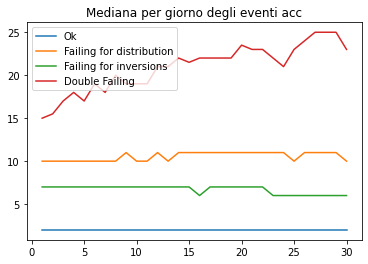

In [13]:
x = [i for i in range(1,31,1)]
plt.plot(x,medians_acc_ok, label = 'Ok')
plt.plot(x,medians_acc_fail_distr, label = 'Failing for distribution')
plt.plot(x,medians_acc_fail_inv, label = 'Failing for inversions ')
plt.plot(x,medians_acc_double_fail, label = 'Double Failing')
plt.title('Mediana per giorno degli eventi acc')
plt.legend()
plt.show()

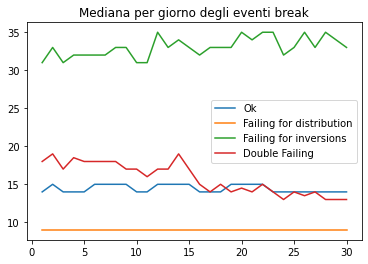

In [14]:
x = [i for i in range(1,31,1)]
plt.plot(x,medians_brk_ok, label = 'Ok')
plt.plot(x,medians_brk_fail_distr, label = 'Failing for distribution')
plt.plot(x,medians_brk_fail_inv, label = 'Failing for inversions ')
plt.plot(x,medians_brk_double_fail, label = 'Double Failing')
plt.title('Mediana per giorno degli eventi break')
plt.legend()
plt.show()

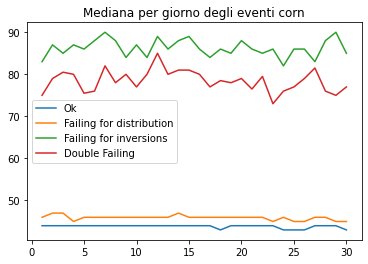

In [15]:
x = [i for i in range(1,31,1)]
plt.plot(x,medians_crn_ok, label = 'Ok')
plt.plot(x,medians_crn_fail_distr, label = 'Failing for distribution')
plt.plot(x,medians_crn_fail_inv, label = 'Failing for inversions ')
plt.plot(x,medians_crn_double_fail, label = 'Double Failing')
plt.title('Mediana per giorno degli eventi corn')
plt.legend()
plt.show()

In [16]:
means_ok = []
for col in df_ok.columns.to_list()[1:91]:
    means_ok.append(st.mean(df_ok[col]))
    
means_acc_ok = means_ok[0:90:3]
means_brk_ok = means_ok[1:90:3]
means_crn_ok = means_ok[2:92:3]

len(means_crn_ok)

means_fail_distr = []
for col in df_fail_distr.columns.to_list()[1:91]:
    means_fail_distr.append(st.mean(df_fail_distr[col]))
    
means_acc_fail_distr = means_fail_distr[0:90:3]
means_brk_fail_distr = means_fail_distr[1:90:3]
means_crn_fail_distr = means_fail_distr[2:91:3]

means_fail_inv = []
for col in df_fail_inv.columns.to_list()[1:91]:
    means_fail_inv.append(st.mean(df_fail_inv[col]))
    
means_acc_fail_inv = means_fail_inv[0:90:3]
means_brk_fail_inv = means_fail_inv[1:90:3]
means_crn_fail_inv = means_fail_inv[2:91:3]

means_double_fail = []
for col in df_double_fail.columns.to_list()[1:91]:
    means_double_fail.append(st.mean(df_double_fail[col]))
    
means_acc_double_fail = means_double_fail[0:90:3]
means_brk_double_fail = means_double_fail[1:90:3]
means_crn_double_fail = means_double_fail[2:91:3]

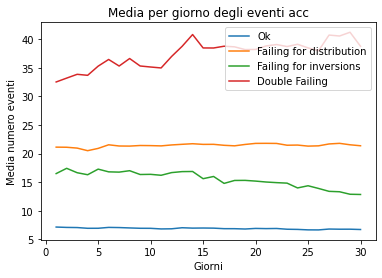

In [17]:
x = [i for i in range(1,31,1)]
plt.plot(x,means_acc_ok, label = 'Ok')
plt.plot(x,means_acc_fail_distr, label = 'Failing for distribution')
plt.plot(x,means_acc_fail_inv, label = 'Failing for inversions ')
plt.plot(x,means_acc_double_fail, label = 'Double Failing')
plt.title('Media per giorno degli eventi acc')
plt.xlabel('Giorni')
plt.ylabel('Media numero eventi')
plt.legend()
plt.show()

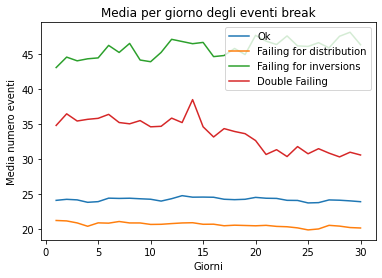

In [18]:
x = [i for i in range(1,31,1)]
plt.plot(x,means_brk_ok, label = 'Ok')
plt.plot(x,means_brk_fail_distr, label = 'Failing for distribution')
plt.plot(x,means_brk_fail_inv, label = 'Failing for inversions ')
plt.plot(x,means_brk_double_fail, label = 'Double Failing')
plt.title('Media per giorno degli eventi break')
plt.xlabel('Giorni')
plt.ylabel('Media numero eventi')
plt.legend()
plt.show()

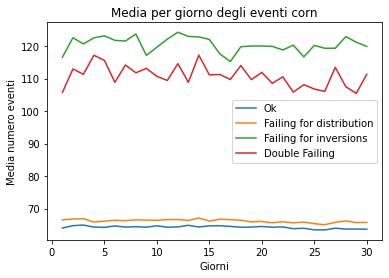

In [19]:
x = [i for i in range(1,31,1)]
plt.plot(x,means_crn_ok, label = 'Ok')
plt.plot(x,means_crn_fail_distr, label = 'Failing for distribution')
plt.plot(x,means_crn_fail_inv, label = 'Failing for inversions ')
plt.plot(x,means_crn_double_fail, label = 'Double Failing')
plt.title('Media per giorno degli eventi corn')
plt.xlabel('Giorni')
plt.ylabel('Media numero eventi')

plt.legend()
plt.show()

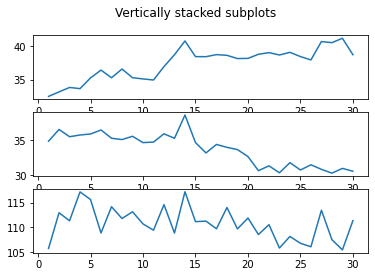

In [20]:
#fig = plt.figure(figsize=(10, 8))
#fig.subplots_adjust(hspace=0.4, wspace=0.3)
fig, axs = plt.subplots(3)
fig.suptitle('Vertically stacked subplots')

#ax = fig.add_subplot(3,3,2)
axs[0].plot(x,means_acc_double_fail, label = 'Double Failing')
axs[1].plot(x,means_brk_double_fail, label = 'Double Failing')
axs[2].plot(x,means_crn_double_fail, label = 'Double Failing')

plt.show()

In [21]:
balancement = df.results.value_counts()
display(balancement)  

Ok                          86504
Failing for distribution    24403
Failing for inversions       2035
Double Failing               1088
Name: results, dtype: int64

[Text(0.5, 1.0, 'Class balancement')]

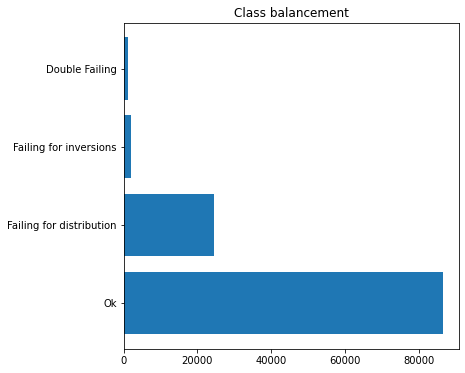

In [22]:
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(balancement.index, balancement)
ax.set(title='Class balancement')

## Binary Dataset

In [23]:
df_bin = df.copy()

res_bin = df_bin['results'].to_list()
fin_bin = res_bin.copy() # collect positions of failed imei

failed = []

for pos in range(0,len(res_bin)):
    if res_bin[pos] != 'Ok':
        failed.append(pos)

for elem in failed:
    fin_bin[elem] = 'Failed'
    
df_bin['results'] = fin_bin
df_bin['results'].unique()

array(['Failed', 'Ok'], dtype=object)

In [24]:
balancement = df_bin.results.value_counts()
display(balancement) 

Ok        86504
Failed    27526
Name: results, dtype: int64

[Text(0.5, 1.0, 'Class balancement')]

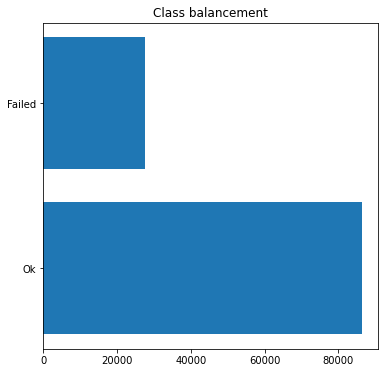

In [25]:
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(balancement.index, balancement)
ax.set(title='Class balancement')

### Binary Dataset balancing

In [26]:
df_ok = df_bin[df_bin['results']=='Ok'].copy()
df_fail = df_bin[df_bin['results']!='Ok'].reset_index().drop(columns='index',axis=0).copy()
n_fail = df_bin[df_bin['results']=='Failed'].results.count().copy()
df_ok = df_ok.sample(n_fail).reset_index().drop(columns='index',axis=0).copy()
df_bal_bin = pd.concat([df_ok,df_fail]).reset_index().drop(columns='index',axis=0).copy()

In [27]:
df_bal_bin.head()

,imei,acc_1,brk_1,corn_1,acc_2,brk_2,corn_2,acc_3,brk_3,corn_3,...,acc_28,brk_28,corn_28,acc_29,brk_29,corn_29,acc_30,brk_30,corn_30,results
0,862239038717980,2.0,43.0,126.0,0.0,16.0,44.0,0.0,10.0,38.0,...,0.0,22.0,38.0,0.0,13.0,45.0,1.0,16.0,68.0,Ok
1,860788040209073,0.0,5.0,19.0,0.0,4.0,74.0,0.0,9.0,52.0,...,0.0,1.0,52.0,0.0,3.0,72.0,0.0,0.0,35.0,Ok
2,861020038835746,3.0,29.0,61.0,4.0,84.0,164.0,0.0,32.0,41.0,...,0.0,20.0,42.0,4.0,33.0,88.0,1.0,31.0,54.0,Ok
3,862345035253810,2.0,4.0,18.0,13.0,109.0,226.0,19.0,172.0,339.0,...,18.0,42.0,81.0,4.0,35.0,75.0,15.0,135.0,319.0,Ok
4,862345035328927,208.0,22.0,271.0,94.0,22.0,130.0,100.0,17.0,139.0,...,10.0,43.0,142.0,8.0,47.0,87.0,10.0,31.0,64.0,Ok


[Text(0.5, 1.0, 'Class balancement')]

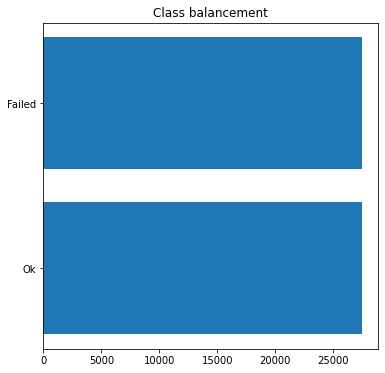

In [28]:
balancement = df_bal_bin.results.value_counts()
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(balancement.index, balancement)
ax.set(title='Class balancement')

In [29]:
balancement

Ok        27526
Failed    27526
Name: results, dtype: int64

## Ternary Dataset
### 'double failed' and 'failed for inversions' are merged

In [30]:
df_ter=df.copy()

res_ter=df_ter['results'].to_list()
fin_ter=res_ter.copy() 

for pos in range(0,len(res_ter)):
    if res_ter[pos] == 'Double Failing':
        res_ter[pos] ='Failing for inversions'


df_ter['results'] = res_ter
df_ter['results'].unique()

array(['Failing for distribution', 'Ok', 'Failing for inversions'],
      dtype=object)

In [31]:
balancement = df_ter.results.value_counts()
display(balancement) 

Ok                          86504
Failing for distribution    24403
Failing for inversions       3123
Name: results, dtype: int64

[Text(0.5, 1.0, 'Class balancement')]

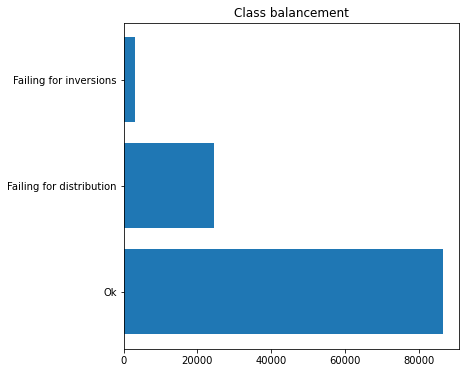

In [32]:
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(balancement.index, balancement)
ax.set(title='Class balancement')

### Ternary Dataset balancing

In [33]:
df_ok = df_ter[df_ter['results']=='Ok'].copy()
df_fail = df_ter[df_ter['results']!='Ok'].reset_index().drop(columns='index',axis=0).copy()
n_fail_distr = df_ter[df_ter['results']=='Failing for distribution'].results.count().copy()
df_ok = df_ok.sample(n_fail_distr).reset_index().drop(columns='index',axis=0).copy()
df_bal_ter = pd.concat([df_ok,df_fail]).reset_index().drop(columns='index',axis=0).copy()

In [34]:
df_bal_ter.head()

,imei,acc_1,brk_1,corn_1,acc_2,brk_2,corn_2,acc_3,brk_3,corn_3,...,acc_28,brk_28,corn_28,acc_29,brk_29,corn_29,acc_30,brk_30,corn_30,results
0,862345036326706,2.0,7.0,15.0,9.0,26.0,48.0,12.0,25.0,15.0,...,12.0,37.0,65.0,15.0,71.0,152.0,0.0,6.0,19.0,Ok
1,861914032432387,2.0,25.0,154.0,3.0,19.0,61.0,1.0,36.0,127.0,...,0.0,29.0,119.0,0.0,2.0,14.0,0.0,14.0,48.0,Ok
2,861914035109644,0.0,5.0,14.0,0.0,3.0,13.0,0.0,5.0,14.0,...,0.0,4.0,8.0,0.0,5.0,14.0,0.0,4.0,8.0,Ok
3,861914034956821,0.0,1.0,19.0,0.0,0.0,17.0,0.0,0.0,19.0,...,0.0,0.0,18.0,0.0,0.0,12.0,1.0,0.0,20.0,Ok
4,861914032872533,0.0,3.0,12.0,1.0,2.0,13.0,1.0,7.0,27.0,...,0.0,0.0,31.0,1.0,1.0,42.0,0.0,0.0,24.0,Ok


[Text(0.5, 1.0, 'Class balancement')]

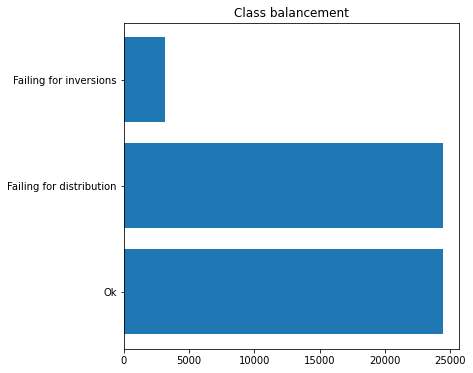

In [35]:
balancement = df_bal_ter.results.value_counts()
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(balancement.index, balancement)
ax.set(title='Class balancement')

## Tree Datasets defining

### Ternary - 'df_tree_ter'

In [36]:
print(df_bal_ter['results'].unique())
df_bal_ok = df_bal_ter[df_bal_ter['results'] == 'Ok'].copy()
df_bal_fail_distr = df_bal_ter[df_bal_ter['results'] == 'Failing for distribution'].copy()
df_bal_fail_inv= df_bal_ter[df_bal_ter['results'] == 'Failing for inversions'].copy()

['Ok' 'Failing for distribution' 'Failing for inversions']


In [37]:
length = df_bal_fail_inv.shape[0]
df_tree = pd.concat([df_bal_fail_inv,df_bal_fail_distr.head(length),df_bal_ok.head(length)]).copy()
df_prova = df_tree.copy()
df_tree_ter = df_tree.reset_index().drop(columns=['index']).copy()
df_tree_ter.head()

,imei,acc_1,brk_1,corn_1,acc_2,brk_2,corn_2,acc_3,brk_3,corn_3,...,acc_28,brk_28,corn_28,acc_29,brk_29,corn_29,acc_30,brk_30,corn_30,results
0,861914036942423,70.0,75.0,223.0,36.0,35.0,174.0,60.0,11.0,423.0,...,69.0,8.0,137.0,99.0,13.0,253.0,33.0,0.0,86.0,Failing for inversions
1,358766019788458,40.0,15.0,44.0,23.0,26.0,160.0,26.0,11.0,133.0,...,5.0,2.0,43.0,24.0,20.0,84.0,21.0,10.0,20.0,Failing for inversions
2,861914036227601,23.0,17.0,36.0,114.0,102.0,280.0,38.0,43.0,55.0,...,70.0,56.0,128.0,55.0,27.0,68.0,64.0,51.0,333.0,Failing for inversions
3,861914036795201,0.0,24.0,34.0,5.0,32.0,33.0,3.0,24.0,36.0,...,3.0,18.0,29.0,3.0,40.0,73.0,7.0,25.0,56.0,Failing for inversions
4,861914033756081,4.0,0.0,14.0,9.0,7.0,81.0,3.0,1.0,14.0,...,1.0,1.0,82.0,23.0,10.0,125.0,13.0,4.0,181.0,Failing for inversions


[Text(0.5, 1.0, 'Class balancement')]

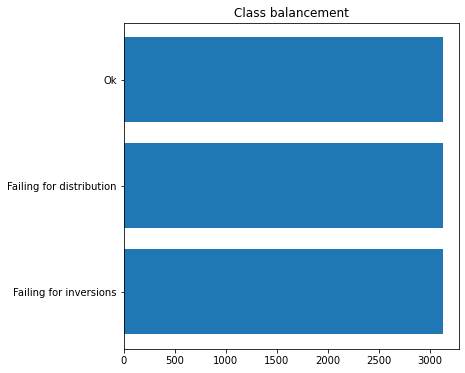

In [38]:
balancement = df_tree_ter.results.value_counts()
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(balancement.index, balancement)
ax.set(title='Class balancement')

### Binary - 'df_tree_bin'

In [39]:
df_tree_bin = df_bal_bin.copy()
print(df_tree_bin.results.unique())
df_tree_bin.head()

['Ok' 'Failed']


,imei,acc_1,brk_1,corn_1,acc_2,brk_2,corn_2,acc_3,brk_3,corn_3,...,acc_28,brk_28,corn_28,acc_29,brk_29,corn_29,acc_30,brk_30,corn_30,results
0,862239038717980,2.0,43.0,126.0,0.0,16.0,44.0,0.0,10.0,38.0,...,0.0,22.0,38.0,0.0,13.0,45.0,1.0,16.0,68.0,Ok
1,860788040209073,0.0,5.0,19.0,0.0,4.0,74.0,0.0,9.0,52.0,...,0.0,1.0,52.0,0.0,3.0,72.0,0.0,0.0,35.0,Ok
2,861020038835746,3.0,29.0,61.0,4.0,84.0,164.0,0.0,32.0,41.0,...,0.0,20.0,42.0,4.0,33.0,88.0,1.0,31.0,54.0,Ok
3,862345035253810,2.0,4.0,18.0,13.0,109.0,226.0,19.0,172.0,339.0,...,18.0,42.0,81.0,4.0,35.0,75.0,15.0,135.0,319.0,Ok
4,862345035328927,208.0,22.0,271.0,94.0,22.0,130.0,100.0,17.0,139.0,...,10.0,43.0,142.0,8.0,47.0,87.0,10.0,31.0,64.0,Ok


[Text(0.5, 1.0, 'Class balancement')]

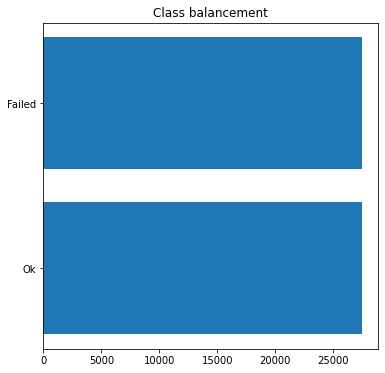

In [40]:
balancement = df_bal_bin.results.value_counts()
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(balancement.index, balancement)
ax.set(title='Class balancement')

# Df Synt

In [41]:
def find_col(stringa: str) -> list[int]:
    """
    Return list of indexes of columns starting with stringa.
    """
    names = df.columns.to_list()
    pos = []
    stringa = str(stringa)
    for column in names:
        if column.startswith(stringa):
            pos.append(1)
        else:
            pos.append(0)        
    fin=[]
    num=0
    while num<len(pos):
        if pos[num]==1:
            fin.append(num)
        num+=1
    return fin

In [42]:
df_acc = df.iloc[:, find_col('acc')]
df_brk = df.iloc[:, find_col('brk')]
df_corn = df.iloc[:, find_col('cor')]

In [43]:
df_ext = df.copy()
df_ext['mean_acc'] = round(df_acc.mean(axis=1),2).to_list()
df_ext['mean_brk'] = round(df_brk.mean(axis=1),2).to_list()
df_ext['mean_corn'] = round(df_corn.mean(axis=1),2).to_list()

In [44]:
df_synt = df_ext[['imei','mean_acc','mean_brk','mean_corn']].copy()

In [45]:
df_synt['max_acc'] = round(df_acc.max(axis=1),2).to_list()
df_synt['max_brk'] = round(df_brk.max(axis=1),2).to_list()
df_synt['max_corn'] = round(df_corn.max(axis=1),2).to_list()

In [46]:
df_synt['var_acc'] = round(df_acc.var(axis=1),2).to_list()
df_synt['var_brk'] = round(df_brk.var(axis=1),2).to_list()
df_synt['var_corn'] = round(df_corn.var(axis=1),2).to_list()

In [47]:
df_synt_var = df_synt[['imei','var_acc','var_brk','var_corn']].copy()

In [48]:
df_synt['results'] = df['results'].copy()
df_synt_var['results'] = df['results'].copy()

In [49]:
df_bin = df.copy()

In [50]:
res_bin = df_bin['results'].to_list()
fin_bin = res_bin.copy() # collect positions of failed imei

In [51]:
failed = []

for pos in range(0,len(res_bin)):
    if res_bin[pos] != 'Ok':
        failed.append(pos)

for elem in failed:
    fin_bin[elem] = 'Failed'
    
df_bin['results'] = fin_bin
df_bin['results'].unique()

array(['Failed', 'Ok'], dtype=object)

Ok        86504
Failed    27526
Name: results, dtype: int64

[Text(0.5, 1.0, 'Class balancement')]

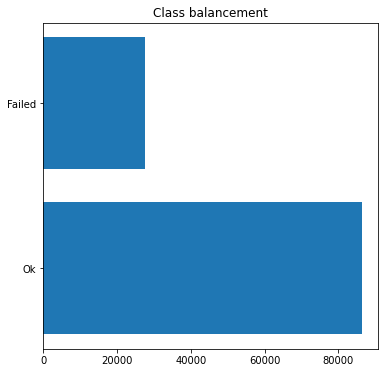

In [52]:
balancement = df_bin.results.value_counts()
display(balancement) 
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(balancement.index, balancement)
ax.set(title='Class balancement')

In [53]:
df_ok=df_bin[df_bin['results']=='Ok']
df_fail=df_bin[df_bin['results']!='Ok'].reset_index().drop(columns='index',axis=0)
n_fail=df_bin[df_bin['results']=='Failed'].results.count()
df_ok=df_ok.sample(n_fail).reset_index().drop(columns='index',axis=0)
df_bal_bin=pd.concat([df_ok,df_fail]).reset_index().drop(columns='index',axis=0)

In [54]:
df_synt_bin = df_synt.copy()
df_synt_bin['results'] = df_bin['results']
df_synt_bin['results'].unique()

array(['Failed', 'Ok'], dtype=object)

# Analisi delle componenti principali (PCA)

In [55]:
from sklearn.preprocessing import StandardScaler

In [56]:
from sklearn.decomposition import PCA

## PCA for ternary df

### Choosing dataset

In [57]:
df_pca_sel = df_ter.copy()

In [58]:
x = df_pca_sel.drop(columns=[imei_col, target]).copy()

df_pca_sel.head()

,imei,acc_1,brk_1,corn_1,acc_2,brk_2,corn_2,acc_3,brk_3,corn_3,...,acc_28,brk_28,corn_28,acc_29,brk_29,corn_29,acc_30,brk_30,corn_30,results
0,861914034070078,0.0,0.0,13.0,0.0,0.0,20.0,0.0,0.0,29.0,...,0.0,0.0,32.0,0.0,0.0,15.0,0.0,0.0,32.0,Failing for distribution
1,860788040171414,0.0,4.0,51.0,4.0,6.0,109.0,0.0,1.0,11.0,...,1.0,2.0,32.0,0.0,1.0,66.0,1.0,9.0,113.0,Ok
2,861914035513118,3.0,2.0,13.0,9.0,16.0,48.0,1.0,5.0,16.0,...,0.0,3.0,18.0,2.0,2.0,13.0,5.0,10.0,38.0,Ok
3,861914034459115,3.0,7.0,22.0,11.0,19.0,83.0,2.0,7.0,36.0,...,51.0,0.0,45.0,81.0,0.0,70.0,61.0,0.0,67.0,Failing for distribution
4,860788040170549,0.0,16.0,37.0,0.0,5.0,29.0,1.0,12.0,41.0,...,2.0,25.0,150.0,0.0,17.0,88.0,0.0,10.0,102.0,Ok


[Text(0.5, 1.0, 'Class balancement')]

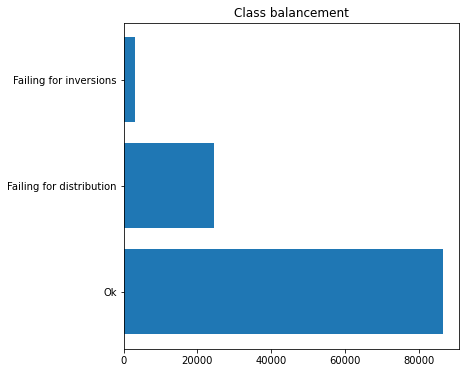

In [59]:
balancement = df_pca_sel.results.value_counts()
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(balancement.index, balancement)
ax.set(title='Class balancement')

### Standardize features

In [60]:
x = StandardScaler().fit_transform(x)

### Creating Principal Components

#### Selecting number of principal components

In [61]:
pca = PCA(n_components=7)

### Fitting components

principal_components = pca.fit_transform(x)


principal_components.shape

pca.explained_variance_ratio_.tolist()

[0.36235709851920167,
 0.1517296318919498,
 0.06913708271306077,
 0.017499835603957382,
 0.014354073330101625,
 0.01370305743917918,
 0.012831647114863912]

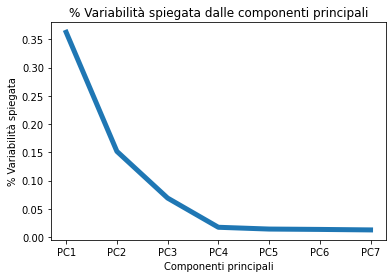

In [62]:
x_axis = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']
y_axis = pca.explained_variance_ratio_.tolist()
plt.plot(x_axis, y_axis, linewidth=5)
plt.xlabel('Componenti principali')
plt.ylabel('% Variabilità spiegata')
plt.title('% Variabilità spiegata dalle componenti principali')

plt.show()

### Number of principal components final decision

In [63]:
pca = PCA(n_components=4)

principal_components = pca.fit_transform(x)

principal_df = pd.DataFrame(data = principal_components
             , columns = ['PC1', 'PC2', 'PC3', 'PC4', 
                          #'PC5', 'PC6', 'PC7'
                         ]).copy()

df_pca_ter = pd.concat([df_pca_sel['imei'], principal_df, df_pca_sel[['results']]], axis = 1)

pca.explained_variance_ratio_.tolist()

round(sum(pca.explained_variance_ratio_.tolist()),2)

0.6

## PCA for binary df

[Text(0.5, 1.0, 'Class balancement')]

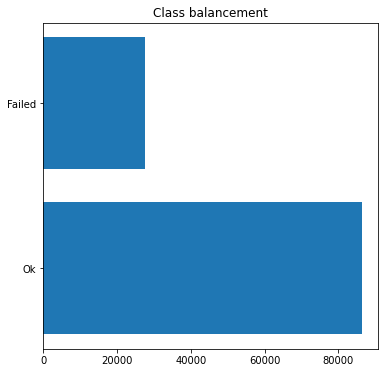

In [64]:
df_pca_sel = df_bin.copy()

x = df_pca_sel.drop(columns=[imei_col, target]).copy()

df_pca_sel.head()

balancement = df_pca_sel.results.value_counts()
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(balancement.index, balancement)
ax.set(title='Class balancement')

### Standardize features

In [65]:
x = StandardScaler().fit_transform(x)

### Creating Principal Components

#### Selecting number of principal components

In [66]:
pca = PCA(n_components=7)

### Fitting components

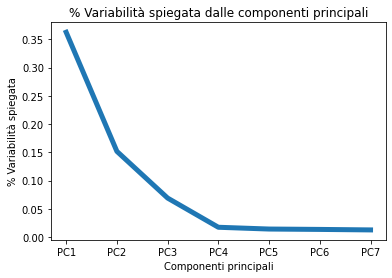

[0.36235709851920467,
 0.15172963189194946,
 0.06913708271305011,
 0.017499839373754014,
 0.014367008346987464,
 0.013693357088862875,
 0.012814817654940032]

In [67]:
principal_components = pca.fit_transform(x)


principal_components.shape

pca.explained_variance_ratio_.tolist()

x_axis = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']
y_axis = pca.explained_variance_ratio_.tolist()
plt.plot(x_axis, y_axis, linewidth=5)
plt.xlabel('Componenti principali')
plt.ylabel('% Variabilità spiegata')
plt.title('% Variabilità spiegata dalle componenti principali')

plt.show()

pca.explained_variance_ratio_.tolist()

### Number of principal components final decision

In [68]:
pca = PCA(n_components=4)

principal_components = pca.fit_transform(x)

principal_df = pd.DataFrame(data = principal_components
             , columns = ['PC1', 'PC2', 'PC3', 'PC4', 
                          #'PC5', 'PC6', 'PC7'
                         ]).copy()

df_pca_bin = pd.concat([df_pca_sel['imei'], principal_df, df_pca_sel[['results']]], axis = 1)

pca.explained_variance_ratio_.tolist()

round(sum(pca.explained_variance_ratio_.tolist()),2)

0.6

# Dataset choose

In [91]:
df_pca_sel = df_tree_bin.copy()

In [92]:
x = df_pca_sel.drop(columns=[imei_col, target]).copy()

In [93]:
df_pca_sel.head()

,imei,acc_1,brk_1,corn_1,acc_2,brk_2,corn_2,acc_3,brk_3,corn_3,...,acc_28,brk_28,corn_28,acc_29,brk_29,corn_29,acc_30,brk_30,corn_30,results
0,862239038717980,2.0,43.0,126.0,0.0,16.0,44.0,0.0,10.0,38.0,...,0.0,22.0,38.0,0.0,13.0,45.0,1.0,16.0,68.0,Ok
1,860788040209073,0.0,5.0,19.0,0.0,4.0,74.0,0.0,9.0,52.0,...,0.0,1.0,52.0,0.0,3.0,72.0,0.0,0.0,35.0,Ok
2,861020038835746,3.0,29.0,61.0,4.0,84.0,164.0,0.0,32.0,41.0,...,0.0,20.0,42.0,4.0,33.0,88.0,1.0,31.0,54.0,Ok
3,862345035253810,2.0,4.0,18.0,13.0,109.0,226.0,19.0,172.0,339.0,...,18.0,42.0,81.0,4.0,35.0,75.0,15.0,135.0,319.0,Ok
4,862345035328927,208.0,22.0,271.0,94.0,22.0,130.0,100.0,17.0,139.0,...,10.0,43.0,142.0,8.0,47.0,87.0,10.0,31.0,64.0,Ok


[Text(0.5, 1.0, 'Class balancement')]

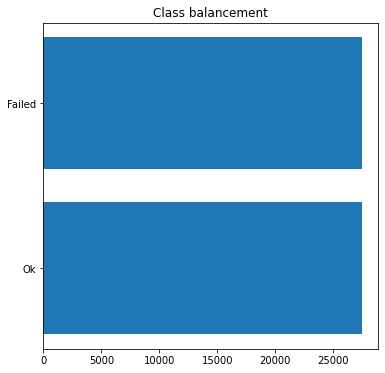

In [94]:
balancement = df_pca_sel.results.value_counts()
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(balancement.index, balancement)
ax.set(title='Class balancement')

Standardize features

In [95]:
x = StandardScaler().fit_transform(x)

### Creating Principal Components

Selecting number of principal components

In [96]:
pca = PCA(n_components=15)

Fitting components

In [97]:
principal_components = pca.fit_transform(x)


In [98]:
principal_components.shape

(55052, 15)

In [99]:
pca.explained_variance_ratio_.tolist()

[0.33709134708756044,
 0.175547743438472,
 0.07808884836416624,
 0.016552029239717766,
 0.013733336976772852,
 0.01318066415906177,
 0.012918133152586433,
 0.012281444449028765,
 0.010514121524688651,
 0.010224180141098353,
 0.01006800647007382,
 0.009841423570528132,
 0.009684691451328598,
 0.009473292321942734,
 0.00917349275724796]

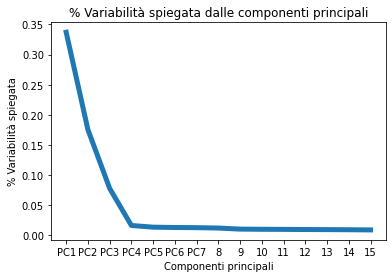

In [100]:
x_axis = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7','8', '9', '10', '11', '12', '13', '14', '15']
y_axis = pca.explained_variance_ratio_.tolist()
plt.plot(x_axis, y_axis, linewidth=5)
plt.xlabel('Componenti principali')
plt.ylabel('% Variabilità spiegata')
plt.title('% Variabilità spiegata dalle componenti principali')

plt.show()


Number of principal components final decision

In [64]:
pca = PCA(n_components=4)

In [65]:
principal_components = pca.fit_transform(x)

In [66]:
principal_df = pd.DataFrame(data = principal_components
             , columns = ['PC1', 'PC2', 'PC3', 'PC4', 
                          #'PC5', 'PC6', 'PC7'
                         ]).copy()

In [67]:
df_pca = pd.concat([df_pca_sel['imei'], principal_df, df_pca_sel[['results']]], axis = 1)

In [68]:
df_pca.head(5)

,imei,PC1,PC2,PC3,PC4,results
0,861914036942423,8.413001,2.244678,0.239036,-0.875701,Failing for inversions
1,358766019788458,2.273696,-3.127045,-0.443202,-0.884144,Failing for inversions
2,861914036227601,6.026926,-4.495796,2.981153,-0.255289,Failing for inversions
3,861914036795201,-0.602460,2.568002,0.067483,0.298469,Failing for inversions
4,861914033756081,-3.257551,-0.985976,-1.393947,0.441020,Failing for inversions


In [69]:
pca.explained_variance_ratio_.tolist()

[0.3161510612287725,
 0.16209103219677432,
 0.07444237498446472,
 0.02286067721615639]

In [70]:
round(sum(pca.explained_variance_ratio_.tolist()),2)

0.58

# Decision Tree Model Training

### Choosing Dataset

In [71]:
df_tree_model = df_tree_ter.copy()
max_depth = None

In [72]:
df_tree_model

,imei,acc_1,brk_1,corn_1,acc_2,brk_2,corn_2,acc_3,brk_3,corn_3,...,acc_28,brk_28,corn_28,acc_29,brk_29,corn_29,acc_30,brk_30,corn_30,results
0,861914036942423,70.0,75.0,223.0,36.0,35.0,174.0,60.0,11.0,423.0,...,69.0,8.0,137.0,99.0,13.0,253.0,33.0,0.0,86.0,Failing for inversions
1,358766019788458,40.0,15.0,44.0,23.0,26.0,160.0,26.0,11.0,133.0,...,5.0,2.0,43.0,24.0,20.0,84.0,21.0,10.0,20.0,Failing for inversions
2,861914036227601,23.0,17.0,36.0,114.0,102.0,280.0,38.0,43.0,55.0,...,70.0,56.0,128.0,55.0,27.0,68.0,64.0,51.0,333.0,Failing for inversions
3,861914036795201,0.0,24.0,34.0,5.0,32.0,33.0,3.0,24.0,36.0,...,3.0,18.0,29.0,3.0,40.0,73.0,7.0,25.0,56.0,Failing for inversions
4,861914033756081,4.0,0.0,14.0,9.0,7.0,81.0,3.0,1.0,14.0,...,1.0,1.0,82.0,23.0,10.0,125.0,13.0,4.0,181.0,Failing for inversions
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9364,862239038681137,6.0,17.0,63.0,5.0,7.0,79.0,12.0,16.0,47.0,...,7.0,15.0,58.0,7.0,11.0,63.0,16.0,23.0,79.0,Ok
9365,860788040152570,5.0,3.0,6.0,2.0,8.0,11.0,4.0,5.0,12.0,...,8.0,10.0,13.0,2.0,7.0,7.0,5.0,7.0,29.0,Ok
9366,861914034464743,20.0,50.0,108.0,9.0,40.0,151.0,6.0,18.0,52.0,...,6.0,14.0,62.0,2.0,21.0,43.0,10.0,21.0,74.0,Ok
9367,862345037024938,0.0,3.0,19.0,0.0,3.0,25.0,0.0,2.0,17.0,...,0.0,8.0,16.0,0.0,4.0,9.0,0.0,18.0,24.0,Ok


In [73]:
if len(df_tree_model.columns.tolist())>10:    
    if len(df_tree_model['results'].unique().tolist()) == 4:
        df_target = df.copy()
    elif len(df_tree_model['results'].unique().tolist()) == 3:
        df_target = df_ter.copy()
    elif len(df_tree_model['results'].unique().tolist()) == 2:
        df_target = df_bin.copy()

elif len(df_tree_model.columns.tolist())<10:
    if len(df_tree_model['results'].unique().tolist()) == 3:
        df_target = df_pca_ter.copy()
    elif len(df_tree_model['results'].unique().tolist()) == 2:
        df_target = df_pca_bin.copy()
        
X_df = df_target.drop(columns=[imei_col, target])
y_df = df_target['results'].to_list()

In [74]:
balancement = df_target['results'].value_counts()
balancement

Ok                          86504
Failing for distribution    24403
Failing for inversions       3123
Name: results, dtype: int64

In [75]:
balancement = df_tree_model.results.value_counts()
balancement

Failing for inversions      3123
Failing for distribution    3123
Ok                          3123
Name: results, dtype: int64

### Training Set balancing

[Text(0.5, 1.0, 'Class balancement')]

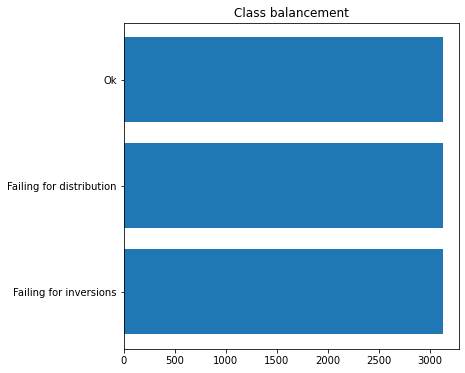

In [76]:
balancement = df_tree_model.results.value_counts()
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(balancement.index, balancement)
ax.set(title='Class balancement')

In [77]:
df_tree_model[target], encoder = cprp.encoding_target_to_int(df_tree_model[target])     
df_tree_model[target].unique()
df_tree_model[target]

0       1
1       1
2       1
3       1
4       1
       ..
9364    2
9365    2
9366    2
9367    2
9368    2
Name: results, Length: 9369, dtype: int32

In [78]:
y_df, encoder = cprp.encoding_target_to_int(y_df)     
y_df

array([0, 2, 2, ..., 0, 0, 0])

In [79]:
y_df

array([0, 2, 2, ..., 0, 0, 0])

In [80]:
#X_df = df_bin.drop(columns=[imei_col, target])
#y_df = df_bin[target].to_list()

In [81]:
if len(df_tree_model['results'].unique().tolist()) == 2:
    for pos in range(0,len(y_df)):
        if y_df[pos] == 'Ok':
            y_df[pos] = 1
        if y_df[pos] == 'Failed':
            y_df[pos] = 0
            
elif len(df_tree_model['results'].unique().tolist()) == 3:
    for pos in range(0,len(y_df)):
        if y_df[pos] == 'Failing for inversions':
            y_df[pos] = 1
        if y_df[pos] == 'Failing for distribution':
            y_df[pos] = 0
        if y_df[pos] == 'Ok':
            y_df[pos] = 2

In [82]:
X = df_tree_model.drop(columns=[imei_col, target])
y = df_tree_model[target]

# Get the X_train and y_train
X_train, X_toy, y_train, y_toy = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42) 

In [83]:
# Get the X_test and y_test
X_toy, X_test, y_toy, y_test = train_test_split(X_df, y_df, train_size=0.8, stratify=y_df, random_state=42) 

In [84]:
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth,
                                  random_state=42)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [85]:
clf_tree.tree_.node_count

2077

In [86]:
clf_tree.get_depth()

26

In [87]:
y_train

7985    2
3496    0
1191    1
4463    0
9045    2
       ..
933     1
5286    0
8185    2
5329    0
1971    1
Name: results, Length: 7495, dtype: int32

Tree Picture

In [88]:
#fig, ax = plt.subplots(figsize=(13, 10))
#tree.plot_tree(clf_tree, fontsize=10,feature_names = list(X.columns))
##plt.savefig("c45_tree_max_depth_3_binary.pdf", format="pdf", bbox_inches="tight")
#plt.show()

In [89]:
y_pred = clf_tree.predict(X_test)

In [90]:
for pos in range(0,len(y_pred)):
    if y_pred[pos] == 'Ok':
        y_pred[pos] = 1
    if y_pred[pos] == 'Failed':
        y_pred[pos] = 0

y_pred = y_pred.tolist()

In [91]:
clf_tree.tree_.node_count

2077

In [92]:
extractor = cmet.ClassificationMetricsExtractor(clf_tree, 'decision_tree', encoder)

In [93]:
y_test

array([2, 2, 2, ..., 2, 2, 2])

In [94]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    report = extractor.classification_report(
        y_test, y_pred,
        save=False,
        filepath=False
    )

                          precision    recall  f1-score   support

Failing for distribution       0.61      0.64      0.63      4881
  Failing for inversions       0.09      0.90      0.17       624
                      Ok       0.94      0.64      0.76     17301

                accuracy                           0.64     22806
               macro avg       0.55      0.73      0.52     22806
            weighted avg       0.85      0.64      0.71     22806



(<Figure size 432x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Confusion Matrix of "decision_tree"'}, xlabel='Predicted labels', ylabel='True labels'>)

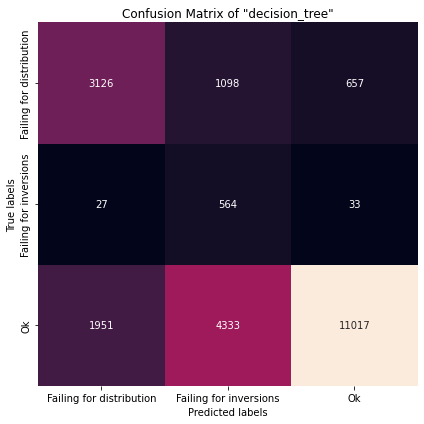

In [95]:
extractor.confusion_matrix_heatmap(
    y_test, y_pred,
    figsize=(6,6),
    save_plot=False,
    #filepath=os.path.join(gc.FIGURE_PATH, f'confusion_matrix_heatmap_{model_name}')
)

In [96]:
# Plot Multiclass ROC Curve
#extractor.roc_curve_multiclass(
#    y_test.values,
#    #clf_tree.predict_proba(X_test),
#    res,
#    figsize=(8,8),
#    save_plot=False,
#    #filepath=os.path.join(gc.FIGURE_PATH, f'multiclass_roc_{model_name}')
#)

In [97]:
# Plot Precision-Recall Curve
#extractor.precision_recall_multiclass(
#    y_test.values, clf_tree.predict_proba(X_test),
#    figsize=(8,8),
#    save_plot=False,
#    #filepath=os.path.join(gc.FIGURE_PATH, f'multiclass_precision_recall_{model_name}')
#)

# Random Forest Model Training

In [115]:
# stopping run all cells
raise ValueError

ValueError: 

### Choosing Dataset

In [98]:
df_rf = df_tree_ter.copy()

In [99]:
df_rf.head()

,imei,acc_1,brk_1,corn_1,acc_2,brk_2,corn_2,acc_3,brk_3,corn_3,...,acc_28,brk_28,corn_28,acc_29,brk_29,corn_29,acc_30,brk_30,corn_30,results
0,861914036942423,70.0,75.0,223.0,36.0,35.0,174.0,60.0,11.0,423.0,...,69.0,8.0,137.0,99.0,13.0,253.0,33.0,0.0,86.0,Failing for inversions
1,358766019788458,40.0,15.0,44.0,23.0,26.0,160.0,26.0,11.0,133.0,...,5.0,2.0,43.0,24.0,20.0,84.0,21.0,10.0,20.0,Failing for inversions
2,861914036227601,23.0,17.0,36.0,114.0,102.0,280.0,38.0,43.0,55.0,...,70.0,56.0,128.0,55.0,27.0,68.0,64.0,51.0,333.0,Failing for inversions
3,861914036795201,0.0,24.0,34.0,5.0,32.0,33.0,3.0,24.0,36.0,...,3.0,18.0,29.0,3.0,40.0,73.0,7.0,25.0,56.0,Failing for inversions
4,861914033756081,4.0,0.0,14.0,9.0,7.0,81.0,3.0,1.0,14.0,...,1.0,1.0,82.0,23.0,10.0,125.0,13.0,4.0,181.0,Failing for inversions


[Text(0.5, 1.0, 'Class balancement')]

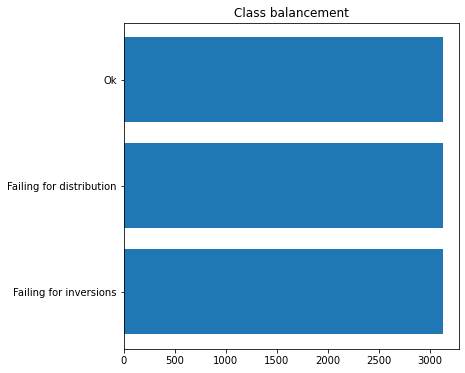

In [100]:
balancement = df_rf.results.value_counts()
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(balancement.index, balancement)
ax.set(title='Class balancement')

In [101]:
if len(df_rf.columns.tolist()) > 10:    
    if len(df_rf['results'].unique().tolist()) == 4:
        df_target = df.copy()
    elif len(df_rf['results'].unique().tolist()) == 3:
        df_target = df_ter.copy()
    elif len(df_rf['results'].unique().tolist()) == 2:
        df_target = df_bin.copy()

elif len(df_rf.columns.tolist()) < 10:
    if len(df_rf['results'].unique().tolist()) == 3:
        df_target = df_pca_ter.copy()
    elif len(df_rf['results'].unique().tolist()) == 2:
        df_target = df_pca_bin.copy()
        
X_df = df_target.drop(columns=[imei_col, target])
y_df = df_target['results'].to_list()

### Settings

In [102]:
model_name = 'random_forest'

In [103]:
df_rf[target]

0       Failing for inversions
1       Failing for inversions
2       Failing for inversions
3       Failing for inversions
4       Failing for inversions
                 ...          
9364                        Ok
9365                        Ok
9366                        Ok
9367                        Ok
9368                        Ok
Name: results, Length: 9369, dtype: object

### Classification preprocessing

In [104]:
# Encodes the target variable to int
df_rf[target], encoder = cprp.encoding_target_to_int(df_rf[target])                
df_rf[target]

0       1
1       1
2       1
3       1
4       1
       ..
9364    2
9365    2
9366    2
9367    2
9368    2
Name: results, Length: 9369, dtype: int32

In [105]:
y_df, encoder = cprp.encoding_target_to_int(y_df)     
y_df

array([0, 2, 2, ..., 0, 0, 0])

In [106]:
if len(df_rf['results'].unique().tolist()) == 2:
    for pos in range(0,len(y_df)):
        if y_df[pos] == 'Ok':
            y_df[pos] = 1
        if y_df[pos] == 'Failed':
            y_df[pos] = 0
            
elif len(df_rf['results'].unique().tolist()) == 3:
    for pos in range(0,len(y_df)):
        if y_df[pos] == 'Failing for inversions':
            y_df[pos] = 1
        if y_df[pos] == 'Failing for distribution':
            y_df[pos] = 0
        if y_df[pos] == 'Ok':
            y_df[pos] = 2

### Train - Validation Test split

In [107]:
X = df_rf.drop(columns=[imei_col, target])
y = df_rf[target]

# Get the X_train and y_train
X_train, X_toy, y_train, y_toy = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42) 

In [108]:
# Get the X_test and y_test
X_toy, X_test, y_toy, y_test = train_test_split(X_df, y_df, train_size=0.8, stratify=y_df, random_state=42) 

#### Selecting right target (from df_bin, df_ter or df)

In [109]:
if len(df_rf['results'].unique().tolist()) == 4:
    df_target = df.copy()
elif len(df_rf['results'].unique().tolist()) == 3:
    df_target = df_ter.copy()
elif len(df_rf['results'].unique().tolist()) == 2:
    df_target = df_bin.copy()

y_df = df_target

### Create pipeline

In [110]:
# Pipeline for preprocessing features
ct = ColumnTransformer(transformers=
    [("scaler", StandardScaler(), make_column_selector(dtype_include=np.number))],  # con scaler standardizzo la varianza dei dati
    remainder='passthrough')
ct

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000022EB6285310>)])

In [111]:
df_rf.head(1)

,imei,acc_1,brk_1,corn_1,acc_2,brk_2,corn_2,acc_3,brk_3,corn_3,...,acc_28,brk_28,corn_28,acc_29,brk_29,corn_29,acc_30,brk_30,corn_30,results
0,861914036942423,70.0,75.0,223.0,36.0,35.0,174.0,60.0,11.0,423.0,...,69.0,8.0,137.0,99.0,13.0,253.0,33.0,0.0,86.0,1


### Tuning of hyperparameters: Grid Search and Random Search

In [112]:
# parameters

n_trees = 400 #numero di alberi

cw = False   #se cw=True, viene usata la class_weight, altrimenti ogni classe ha peso 1

crit = 'entropy'# indica il criterio di scelta nello split, di default è criterion='gini'

depth = None #max_depth indica la massima profondità dell'albero, se max_depth=None allora l'albero si espande finchè
#le foglie sono pure o finchè le foglie contengono meno samples di min_samples_split (di default max_depth=None)

min_split = 15 #The minimum number of samples required to be at a leaf node. A split point at any depth will only be 
            # considered if it leaves at least min_samples_leaf training samples in each of the left and right branches.

max_feat = 50#'auto' # default value: sqrt(number of features)

bs = True # se bs=True, sono usati dei campioni bootstrap quando si costruiscono gli alberi (bootstrap è di default True)

if bs == True:
    boot_samples = 2   #max_samples imposta il numero di campioni estratti da X per fare allenare 
else:                  #ogni stimatore (base estimator). Di default il valore di max_samples è X_train.shape[0]
    boot_samples=None   

### Final Pipeline

In [113]:
model = Pipeline(
        steps=[('preprocessing', ct),
               ('random_forest', RandomForestClassifier(n_estimators=n_trees,
                                                       #bootstrap=bs,
                                                       criterion=crit,
                                                       #max_depth=depth,
                                                       min_samples_leaf=min_split,
                                                       max_features=50,
                                                       #max_samples=boot_samples,
                                                        #n_jobs=-1,
                                                        random_state=42))])

search_model = RandomForestClassifier()

### Fit on training data

In [90]:
model.fit(X_train, y_train)

### Make prediction on validation data

In [ ]:
from collections import Counter
y_pred = model.predict(X_test)
Counter(y_pred).keys() # equals to list(set(words))
Counter(y_pred).values() # counts the elements' frequency

In [ ]:
Counter(y_test).keys() # equals to list(set(words))
Counter(y_test).values() # counts the elements' frequency

In [ ]:
Counter(y_pred).keys() # equals to list(set(words))


### Extract Classification Metrics

In [ ]:
extractor = cmet.ClassificationMetricsExtractor(model, model_name, encoder)

In [ ]:
# Get the classification report
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    report = extractor.classification_report(
        y_test, y_pred,
        save=False,
        filepath=False
    )

In [ ]:
# Get confusion matrix heatmap
extractor.confusion_matrix_heatmap(
    y_test, y_pred,
    figsize=(6,6),
    save_plot=False,
    #filepath=os.path.join(gc.FIGURE_PATH, f'confusion_matrix_heatmap_{model_name}')
)

# Plot Multiclass ROC Curve
extractor.roc_curve_multiclass(
    y_test.values, model.predict_proba(X_test),
    figsize=(8,8),
    save_plot=False,
    #filepath=os.path.join(gc.FIGURE_PATH, f'multiclass_roc_{model_name}')
)

# Plot Precision-Recall Curve
extractor.precision_recall_multiclass(
    y_test.values, model.predict_proba(X_test),
    figsize=(8,8),
    save_plot=False,
    #filepath=os.path.join(gc.FIGURE_PATH, f'multiclass_precision_recall_{model_name}')
)

# Compute Micro and Weighted AUC (Area Under the ROC)
auc = extractor.roc_auc(y_test.values, model.predict_proba(X_test))
display(auc)

### Final Testing with a new Dataset

In [ ]:
#test_filename = ''

#df_final_testing = pd.read_csv(os.path.join(os.getenv('GitHub'), 
                                #'driving_behavior_analysis',
                                #'results',
                                #'merged',
                                #test_filename))

### Grid Search

In [ ]:
n_estimators = [100,150,200]
#class_weight = [None,'balanced']
#bootstrap = ['True','False']
criterion = ['gini','entropy']
max_depth = [None]
min_samples_leaf = [i for i in range(0,51)]
max_features = ['auto', 'sqrt', 'log2',9]
max_samples = [i for i in range(5000,X_train.shape[0]+1,10000)]
n_jobs = [-1]
random_state = 42

In [ ]:
param_grid_search={'n_estimators' : n_estimators,
            'class_weight' : class_weight,
            'bootstrap' : bootstrap,
            'criterion' : criterion,
            'min_samples_leaf' : min_samples_leaf,
            'max_features' : max_features,
            'max_samples' : max_samples}

grid_search = GridSearchCV(estimator = search_model,
                           param_grid = param_grid_search,
                           n_jobs = -1,
                           verbose = 10,
                           cv = 5)

grid_search.fit(X_train, y_train)

grid_search.best_params_

### Random Search

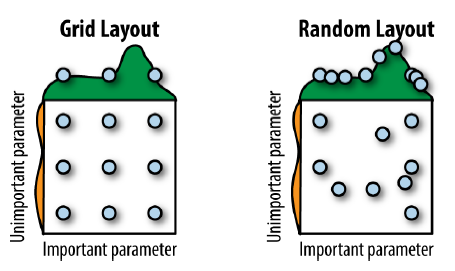

In [ ]:
param_random_search={'n_estimators' : random.sample([i for i in range(100,201)],5),
            'class_weight' : class_weight,
            'bootstrap' : bootstrap,
            'criterion' : criterion,
            'min_samples_leaf' : random.sample([i for i in range(0,51)],5),
            'max_features' : max_features,
            'max_samples' : random.sample([i for i in range(0,X_train.shape[0]+1)],50)}

random_search = GridSearchCV(estimator = search_model,
                           param_grid = param_random_search,
                           n_jobs = -1,
                           verbose = 2,
                           cv = 5)

random_search.fit(X_train, y_train)

random_search.best_params_

# Associative classifier

In [198]:
st.median(df['acc_1'])

3.0

In [199]:
st.stdev(df['acc_1'])

20.065320806488813

In [200]:
st.median(df['brk_1'])

13.0

In [201]:
st.stdev(df['brk_1'])

30.77395176368318

In [202]:
st.median(df['corn_1'])

45.0

In [203]:
st.stdev(df['corn_1'])

66.96966982696968

In [195]:
unici = df['acc_1'].unique().tolist()
count = []
for elem in unici:
    count.append(len(df[df['acc_1'] == elem]))
    
count_perc = []
for elem in count:
    count_perc.append(elem/sum(count))

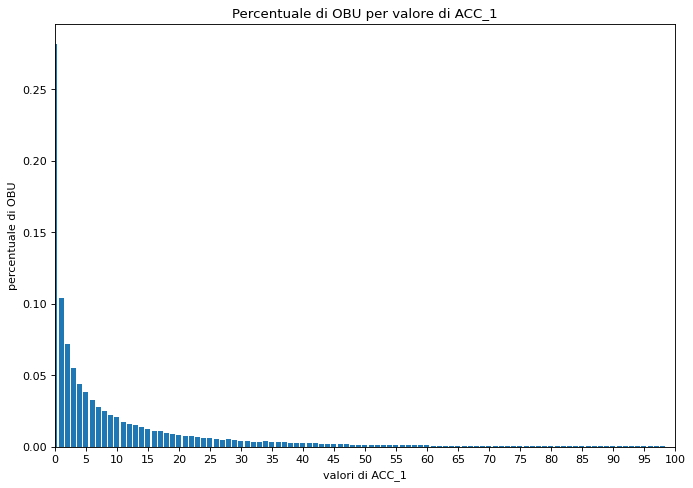

In [547]:
from matplotlib.pyplot import figure

figure(figsize=(10, 7), dpi=80)

plt.bar(unici, count_perc)
plt.xticks([i for i in range(0,101,5)])
plt.xlabel('valori di ACC_1')
plt.ylabel('percentuale di OBU')
plt.title('Percentuale di OBU per valore di ACC_1')
plt.xlim(0,100)
#plt.ylim(0,100)
plt.show()
#plt.xlim(0,521)

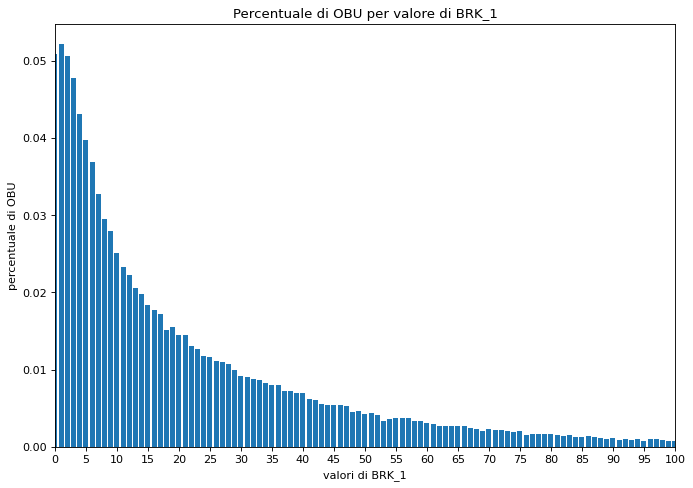

In [541]:
unici = df['brk_1'].unique().tolist()
count = []
for elem in unici:
    count.append(len(df[df['brk_1'] == elem]))


count_perc = []
for elem in count:
    count_perc.append(elem/sum(count))

figure(figsize=(10, 7), dpi=80)

plt.bar(unici, count_perc)
plt.xticks([i for i in range(0,101,5)])
plt.xlabel('valori di BRK_1')
plt.ylabel('percentuale di OBU')
plt.title('Percentuale di OBU per valore di BRK_1')
plt.xlim(0,100)
#plt.ylim(0,6000)
plt.show()
#plt.xlim(0,521)

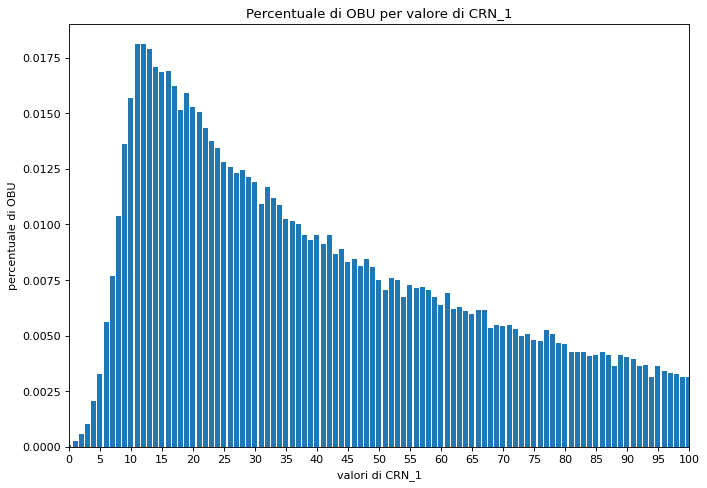

In [542]:
unici = df['corn_1'].unique().tolist()
count = []
for elem in unici:
    count.append(len(df[df['corn_1'] == elem]))

count_perc = []
for elem in count:
    count_perc.append(elem/sum(count))

figure(figsize=(10, 7), dpi=80)

plt.bar(unici, count_perc)
plt.xticks([i for i in range(0,101,5)])
plt.xlabel('valori di CRN_1')
plt.ylabel('percentuale di OBU')
plt.title('Percentuale di OBU per valore di CRN_1')
plt.xlim(0,100)
#plt.ylim(0,2300)
plt.show()
#plt.xlim(0,521)

In [340]:
dataset: list[list] = [means_acc_ok, means_acc_fail_inv, means_acc_fail_distr, means_acc_double_fail]

## Choosing Dataset

In [181]:
df_prov = df.copy()

In [182]:
df_apr = pd.DataFrame()
x_columns = ['acc_1', 'brk_1', 'corn_1', 'acc_2', 'brk_2', 'corn_2', 'acc_3',
       'brk_3', 'corn_3', 'acc_4', 'brk_4', 'corn_4', 'acc_5', 'brk_5',
       'corn_5', 'acc_6', 'brk_6', 'corn_6', 'acc_7', 'brk_7', 'corn_7',
       'acc_8', 'brk_8', 'corn_8', 'acc_9', 'brk_9', 'corn_9', 'acc_10',
       'brk_10', 'corn_10', 'acc_11', 'brk_11', 'corn_11', 'acc_12', 'brk_12',
       'corn_12', 'acc_13', 'brk_13', 'corn_13', 'acc_14', 'brk_14', 'corn_14',
       'acc_15', 'brk_15', 'corn_15', 'acc_16', 'brk_16', 'corn_16', 'acc_17',
       'brk_17', 'corn_17', 'acc_18', 'brk_18', 'corn_18', 'acc_19', 'brk_19',
       'corn_19', 'acc_20', 'brk_20', 'corn_20', 'acc_21', 'brk_21', 'corn_21',
       'acc_22', 'brk_22', 'corn_22', 'acc_23', 'brk_23', 'corn_23', 'acc_24',
       'brk_24', 'corn_24', 'acc_25', 'brk_25', 'corn_25', 'acc_26', 'brk_26',
       'corn_26', 'acc_27', 'brk_27', 'corn_27', 'acc_28', 'brk_28', 'corn_28',
       'acc_29', 'brk_29', 'corn_29', 'acc_30', 'brk_30', 'corn_30']
bins = [0,3,6,8,10,15,20,25,30,35,40,45,50, 100, 200, 10000]
for col in x_columns:
    # if col.startswith('acc'):
    #    continue
    df_apr[col+"_binned"] = pd.cut(df_prov[col], bins, include_lowest=True, right=False)

if len(df_apr[df_apr.isna().any(axis=1)]) != 0:
    raise ValueError("Nan are present!!")
    
df_apr = df_apr.astype(str)
for col in df_apr.columns:
    df_apr[col] = col + df_apr[col]
df_apr['results'] = df_prov['results']

### Apriori for df_synt

In [180]:
df_prov = df_synt
df_prov

,imei,mean_acc,mean_brk,mean_corn,max_acc,max_brk,max_corn,var_acc,var_brk,var_corn,results
0,861914034070078,0.03,0.00,24.53,1.0,0.0,46.0,0.03,0.00,90.60,Failing for distribution
1,860788040171414,1.20,3.93,65.97,7.0,16.0,152.0,2.30,12.62,1728.38,Ok
2,861914035513118,5.27,6.83,26.40,22.0,16.0,77.0,18.27,16.76,251.49,Ok
3,861914034459115,15.50,12.10,57.77,81.0,40.0,144.0,440.60,102.37,1150.46,Failing for distribution
4,860788040170549,0.70,17.93,61.17,7.0,50.0,238.0,2.29,171.72,3248.21,Ok
...,...,...,...,...,...,...,...,...,...,...,...
114025,861914036980704,6.03,13.53,46.90,24.0,41.0,117.0,39.76,143.36,713.47,Failing for distribution
114026,861914036980746,0.40,3.60,32.27,3.0,12.0,92.0,0.59,7.83,420.00,Ok
114027,861914036980811,0.03,66.43,34.63,1.0,182.0,97.0,0.03,1768.74,619.21,Failing for distribution
114028,861914036980811,0.17,58.13,28.10,3.0,171.0,93.0,0.35,1562.12,413.47,Failing for distribution


In [181]:
x_columns = df_synt.columns.to_list()[1:10]
x_columns

['mean_acc',
 'mean_brk',
 'mean_corn',
 'max_acc',
 'max_brk',
 'max_corn',
 'var_acc',
 'var_brk',
 'var_corn']

In [184]:
df_apr = pd.DataFrame()
bins = [0,3,6,8,10,15,20,25,30,35,40,45,50, 100, 200, 10000]
for col in x_columns:
    # if col.startswith('acc'):
    #    continue
    df_apr[col+"_binned"] = pd.cut(df_prov[col], bins, include_lowest=True, right=False)

#if len(df_apr[df_apr.isna().any(axis=1)]) != 0:
#    raise ValueError("Nan are present!!")
    
df_apr = df_apr.astype(str)
for col in df_apr.columns:
    df_apr[col] = col + df_apr[col]
df_apr['results'] = df_prov['results']

### Testing pd.cut

In [184]:
#test_df = pd.DataFrame({'a': [1, 0, 1, 2]})
#test_df['bins'] = pd.cut(test_df['a'], bins=[-1, 0, 1, 2], include_lowest=True)
#
#test_df

In [185]:
te = TransactionEncoder()
te_ary = te.fit(df_apr.values).transform(df_apr.values)
df_apriori = pd.DataFrame(te_ary, columns=te.columns_)

In [189]:
df_apriori

,Double Failing,Failing for distribution,Failing for inversions,Ok,"max_acc_binned[0, 3)","max_acc_binned[10, 15)","max_acc_binned[100, 200)","max_acc_binned[15, 20)","max_acc_binned[20, 25)","max_acc_binned[200, 10000)",...,"var_corn_binned[25, 30)","var_corn_binned[3, 6)","var_corn_binned[30, 35)","var_corn_binned[35, 40)","var_corn_binned[40, 45)","var_corn_binned[45, 50)","var_corn_binned[50, 100)","var_corn_binned[6, 8)","var_corn_binned[8, 10)",var_corn_binnednan
0,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114025,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
114026,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
114027,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
114028,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [190]:
frequent_itemsets = apriori(df_apriori, min_support=0.4, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.758607,(Ok)
1,0.407744,"(mean_acc_binned[0, 3))"
2,0.402315,"(var_brk_binned[200, 10000))"
3,0.769736,"(var_corn_binned[200, 10000))"
4,0.580093,"(var_corn_binned[200, 10000), Ok)"


In [191]:
def get_length(x):
    return len(x)


frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(get_length)

In [192]:
frequent_itemsets

,support,itemsets,length
0,0.758607,(Ok),1
1,0.407744,"(mean_acc_binned[0, 3))",1
2,0.402315,"(var_brk_binned[200, 10000))",1
3,0.769736,"(var_corn_binned[200, 10000))",1
4,0.580093,"(var_corn_binned[200, 10000), Ok)",2


In [193]:
frequent_itemsets['length'].max()

2

In [194]:
frequent_itemsets[frequent_itemsets['length']==frequent_itemsets['length'].max()]#.itemsets.to_list()

,support,itemsets,length
4,0.580093,"(var_corn_binned[200, 10000), Ok)",2


In [192]:
ass_rul = association_rules(frequent_itemsets, metric='confidence', #min_threshold=0.8,
                            support_only=False)
ass_rul

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(acc_11_binned[0, 3))",(Ok),0.459230,0.758607,0.400351,0.871787,1.149194,0.051975,1.882747
1,"(acc_18_binned[0, 3))",(Ok),0.459476,0.758607,0.401166,0.873096,1.150920,0.052605,1.902169
2,"(acc_22_binned[0, 3))",(Ok),0.457713,0.758607,0.400184,0.874313,1.152523,0.052960,1.920580
3,"(acc_23_binned[0, 3))",(Ok),0.459291,0.758607,0.401272,0.873675,1.151683,0.052850,1.910891
4,"(acc_24_binned[0, 3))",(Ok),0.460668,0.758607,0.402315,0.873330,1.151227,0.052849,1.905674
5,"(acc_25_binned[0, 3))",(Ok),0.462124,0.758607,0.403429,0.872988,1.150778,0.052858,1.900557
6,"(acc_26_binned[0, 3))",(Ok),0.461107,0.758607,0.403113,0.874230,1.152414,0.053314,1.919314
7,"(acc_28_binned[0, 3))",(Ok),0.460168,0.758607,0.401368,0.872220,1.149765,0.052281,1.889127
8,"(acc_29_binned[0, 3))",(Ok),0.460975,0.758607,0.401868,0.871778,1.149182,0.052169,1.882612
9,"(acc_30_binned[0, 3))",(Ok),0.461449,0.758607,0.402596,0.872461,1.150082,0.052537,1.892689


In [177]:
#ass_rul['consequents'].unique()

In [193]:
ass_rul[ass_rul['consequents']==ass_rul['consequents'][0]]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(acc_11_binned[0, 3))",(Ok),0.459230,0.758607,0.400351,0.871787,1.149194,0.051975,1.882747
1,"(acc_18_binned[0, 3))",(Ok),0.459476,0.758607,0.401166,0.873096,1.150920,0.052605,1.902169
2,"(acc_22_binned[0, 3))",(Ok),0.457713,0.758607,0.400184,0.874313,1.152523,0.052960,1.920580
3,"(acc_23_binned[0, 3))",(Ok),0.459291,0.758607,0.401272,0.873675,1.151683,0.052850,1.910891
4,"(acc_24_binned[0, 3))",(Ok),0.460668,0.758607,0.402315,0.873330,1.151227,0.052849,1.905674
5,"(acc_25_binned[0, 3))",(Ok),0.462124,0.758607,0.403429,0.872988,1.150778,0.052858,1.900557
6,"(acc_26_binned[0, 3))",(Ok),0.461107,0.758607,0.403113,0.874230,1.152414,0.053314,1.919314
7,"(acc_28_binned[0, 3))",(Ok),0.460168,0.758607,0.401368,0.872220,1.149765,0.052281,1.889127
8,"(acc_29_binned[0, 3))",(Ok),0.460975,0.758607,0.401868,0.871778,1.149182,0.052169,1.882612
9,"(acc_30_binned[0, 3))",(Ok),0.461449,0.758607,0.402596,0.872461,1.150082,0.052537,1.892689


# Isolation Forest

### Choosing Dataset

In [151]:
df_if = df_pca_bin.copy()
df_res = df_if['results'].copy()

Remove imei and results columns

In [152]:
df_if = df_if.drop(columns=['imei', 'results']).copy()

### Choosing parameters

In [153]:
model = IsolationForest(n_estimators=150,
                        #max_samples=5000,
                        contamination=0.04,#float(0.24139261597825135),
                        max_features=9,
                        random_state = 42
)
model.fit(df_if)

C:\Users\Dell\miniconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.04, max_features=9, n_estimators=150,
                random_state=42)

### Fit isolation forest model

In [154]:
model.fit(df_if)

C:\Users\Dell\miniconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.04, max_features=9, n_estimators=150,
                random_state=42)

In [155]:
df_if['scores'] = model.decision_function(df_if)

In [156]:
df_if['scores']

0         0.183026
3         0.157783
9         0.137665
11        0.149436
24        0.178573
            ...   
114023    0.185356
114025    0.166700
114027    0.099460
114028    0.109114
114029    0.133072
Name: scores, Length: 27526, dtype: float64

In [157]:
df_if['anomaly'] = model.predict(df_if.drop(columns='scores'))

In [158]:
df_if['anomaly'] # -1 è anomalia

0         1
3         1
9         1
11        1
24        1
         ..
114023    1
114025    1
114027    1
114028    1
114029    1
Name: anomaly, Length: 27526, dtype: int32

In [159]:
pred = df_if['anomaly'].to_list()
pred_fail = {i for i,x in enumerate(pred) if x == -1} # lista posizioni obu predetti come fail
pred_ok = {i for i,x in enumerate(pred) if x == 1} # lista posizioni obu predetti come ok

res = df_res.to_list()
res_fail = {i for i,x in enumerate(res) if x == 'Failed'} # lista posizioni fail
res_ok = {i for i,x in enumerate(res) if x == 'Ok'} # lista posizioni ok

In [168]:
correct_fail = 0
wrong_fail = 0
for elem in res_fail:
    if elem in pred_fail:
        correct_fail += 1
    else:
        wrong_fail += 1

In [169]:
correct_ok = 0
wrong_ok = 0
for elem in res_ok:
    if elem in pred_ok:
        correct_ok += 1
    else:
        wrong_ok += 1 

In [170]:
wrong_fail

940

In [171]:
print('TP: OBU failed correctly predicted',correct_fail)
print('FP: OBU failed wrongly predicted  ',wrong_fail)

print('TN: OBU ok correctly predicted    ',correct_ok)        
print('FN: OBU ok wrongly predicted      ',wrong_ok)

TP: OBU failed correctly predicted 148
FP: OBU failed wrongly predicted   940
TN: OBU ok correctly predicted     25485
FN: OBU ok wrongly predicted       953


In [164]:
y_df = df_res.to_list()
y_df, encoder = cprp.encoding_target_to_int(y_df)     
y_df # 0 è failed e 1 è Ok

array([1, 1, 1, ..., 1, 1, 1])

In [165]:
extractor = cmet.ClassificationMetricsExtractor(model, 'isolation_tree', encoder)

In [140]:
pred_fin = pred.copy()
for i in pred_fin:
    if i == -1:
        pred_fin[pred_fin.index(i)] = 0

Metriche

(<Figure size 432x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Confusion Matrix of "isolation_tree"'}, xlabel='Predicted labels', ylabel='True labels'>)

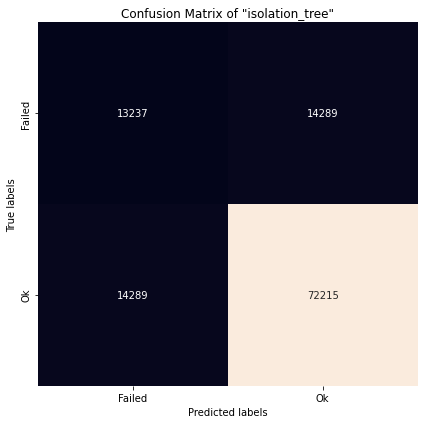

In [141]:
extractor.confusion_matrix_heatmap(
    y_df, pred_fin,
    figsize=(6,6),
    save_plot=False,
    #filepath=os.path.join(gc.FIGURE_PATH, f'confusion_matrix_heatmap_{model_name}')
)

In [142]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    report = extractor.classification_report(
        y_df, pred_fin,
        save=False,
        filepath=False
    )

              precision    recall  f1-score   support

      Failed       0.48      0.48      0.48     27526
          Ok       0.83      0.83      0.83     86504

    accuracy                           0.75    114030
   macro avg       0.66      0.66      0.66    114030
weighted avg       0.75      0.75      0.75    114030

